# I- Contexte

Vous êtes consultant Data Analyst dans une entreprise spécialisée dans la data. Votre entreprise a décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM).  

<img src="img/logo_oncfm.png" style="display: block; margin-left: auto; margin-right: auto; width: 100%;"/>   

Cette institution a pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Ils font donc appel à vous, spécialiste de la data, pour mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent. 

Voici le cahier des charges de l’ONCFM [cahier des charges](doc/cahier_des_charges.pdf) ainsi que le jeu de données [billets.csv](data_raw/billets.csv)  

Le client souhaite que vous travailliez directement depuis ses locaux sous la responsabilité de Marie, responsable du projet d’analyse de données à l’ONCFM.  
Elle vous laissera une grande autonomie pendant votre mission, et vous demande simplement que vous lui présentiez vos résultats une fois la mission terminée.   
Elle souhaite voir quels sont les traitements et analyses que vous avez réalisés en amont, les différentes pistes explorées pour la construction de l’algorithme, ainsi que le modèle final retenu.

Après avoir lu en détail le cahier des charges, vous vous préparez à vous rendre à l’ONCFM pour prendre vos nouvelles fonctions. Vous notez tout de même un post-it qui se trouve sur le coin de votre bureau, laissé par un de vos collègues :

In [98]:
# import des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score

# II- Importation des fichiers

In [4]:
# Lecture du fichier avec ; comme séparateur
data = pd.read_csv("data_raw/billets.csv", sep=';')

# Affiche les 5 premières lignes
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# III- Résumé des datas

In [5]:
# On affiche le type de variables, le nombre de valeur pour chacune
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [6]:
# On affiche un résumé des datas notamment avec le nombre de valeurs uniques pour la colonne type bool
data.describe(include="all")

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


Nous avons un dataframe composé de 7 colonnes et 1 500 lignes  
1 colonne de type boléenne avec 1 000 "True" et 500 "False"  
6 colonnes de type float  
la colonne margin_low ne contient que 14 63 valeurs

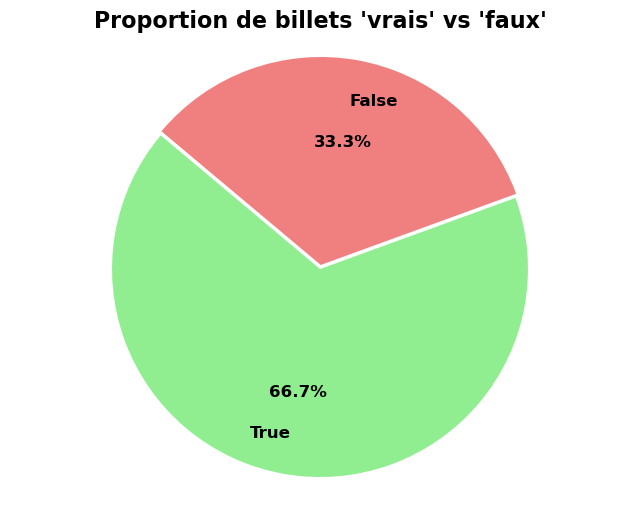

In [7]:
plt.figure(figsize=(8, 6))
counts = data["is_genuine"].value_counts() # compte le nombre de valeurs unique dans la colonne 'is_genuine'
plt.pie(
    counts, # données utilisées pour le pie
    labels=counts.index, # label 'true' ou 'false'
    colors=["lightgreen", "lightcoral"], # couleurs sympa ;-)
    autopct="%1.1f%%", # affiche les pourcentage
    startangle=140, # angle de départ
    explode=(0, 0.02), # Exagération d'une tranche
    labeldistance=0.8, # Distance des labels par rapport au centre
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'}  # Propriétés de la police des labels
)
plt.axis("equal")
plt.title("Proportion de billets 'vrais' vs 'faux'", fontsize=16, fontweight='bold', color='black', loc='center')
plt.show()

Je vais stocker les lignes pour lesquelles la colonne margin_low est vide

In [8]:
# création d'un sous dataframe avec uniquement les lignes ou margin_low est vide "NaN"
missing_margin_low = data[data["margin_low"].isna()]

In [9]:
# compte le nombre de ligne de ce sous dataframe
print("il y a ", len(missing_margin_low), "lignes pour lesquelles 'margin_low' est 'NaN'")

il y a  37 lignes pour lesquelles 'margin_low' est 'NaN'


In [10]:
# Imprimer un résumé des dimensions du DataFrame
print("En résumé, nous avons un DataFrame composé :\n",
      f"- de {data.shape[0]} lignes\n",  # Nombre de lignes
      f"- de {data.shape[1]} colonnes\n",  # Nombre de colonnes
      f"- des colonnes : {data.columns.tolist()}\n"  # Liste des noms des colonnes
     )

# Afficher le nombre de types de variables uniques et leur liste
print(f"Il y a {len(data.dtypes.unique())} types de variables : {data.dtypes.unique()}\n")

# Lister les types de données et les colonnes correspondantes
types_uniques = data.dtypes.unique()  # Récupérer les types de données uniques dans le DataFrame
for type_variable in types_uniques:
    # Filtrer les colonnes correspondant à chaque type de données
    colonnes_par_type = data.columns[data.dtypes == type_variable].tolist()
    
    # Afficher le type de données et les colonnes associées
    print(f"La ou les colonnes de type {type_variable} sont : {', '.join(colonnes_par_type)}\n")

# Lister les colonnes contenant des valeurs NaN
colonnes_avec_nan = data.columns[data.isna().any()].tolist()  # Récupérer les colonnes avec des NaN
for miss_val_col in colonnes_avec_nan:
    # Compter le nombre de valeurs manquantes dans la colonne en cours
    miss_val_numb = data[miss_val_col].isna().sum()  
    
    # Afficher le résultat pour la colonne actuelle
    print(f"Dans la colonne '{miss_val_col}', il manque {miss_val_numb} valeurs.\n\n")

En résumé, nous avons un DataFrame composé :
 - de 1500 lignes
 - de 7 colonnes
 - des colonnes : ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

Il y a 2 types de variables : [dtype('bool') dtype('float64')]

La ou les colonnes de type bool sont : is_genuine

La ou les colonnes de type float64 sont : diagonal, height_left, height_right, margin_low, margin_up, length

Dans la colonne 'margin_low', il manque 37 valeurs.




Observons la moyenne de chaque colonne en fonction de la valeur de "is_genuine" "True" ou "False"

In [11]:
colonnes_numeriques = data.select_dtypes(include=['number']).columns.tolist() #récupérer les colonnes numériques
for num_col in colonnes_numeriques:
    true_mean_col = data[data['is_genuine']][num_col].mean() # calcul la moyenne des colonnes pour is_genuine True
    false_mean_col = data[~data['is_genuine']][num_col].mean() # calcul la moyenne des colonnes pour is_genuine False
    print(f"La moyenne de la colonne '{num_col}' pour les valeurs 'True' est : {true_mean_col:.2f}")
    print(f"La moyenne de la colonne '{num_col}' pour les valeurs 'False' est : {false_mean_col:.2f}")

La moyenne de la colonne 'diagonal' pour les valeurs 'True' est : 171.99
La moyenne de la colonne 'diagonal' pour les valeurs 'False' est : 171.90
La moyenne de la colonne 'height_left' pour les valeurs 'True' est : 103.95
La moyenne de la colonne 'height_left' pour les valeurs 'False' est : 104.19
La moyenne de la colonne 'height_right' pour les valeurs 'True' est : 103.81
La moyenne de la colonne 'height_right' pour les valeurs 'False' est : 104.14
La moyenne de la colonne 'margin_low' pour les valeurs 'True' est : 4.12
La moyenne de la colonne 'margin_low' pour les valeurs 'False' est : 5.22
La moyenne de la colonne 'margin_up' pour les valeurs 'True' est : 3.05
La moyenne de la colonne 'margin_up' pour les valeurs 'False' est : 3.35
La moyenne de la colonne 'length' pour les valeurs 'True' est : 113.20
La moyenne de la colonne 'length' pour les valeurs 'False' est : 111.63


Ou sous forme de dataframe pour plus de clarté

In [12]:
resultats = data.groupby("is_genuine").agg(lambda x: x.mean(skipna=True)
                                           if x.dtype in ["float64", "int64"]
                                           else None)
resultats.round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90,104.19,104.14,5.22,3.35,111.63
True,171.99,103.95,103.81,4.12,3.05,113.20


# IV- Remplacement des valeurs manquantes

Nous allons tenter de déterminer les valeurs manquantes de "margin_low" à l'aide des autres variables en réalisant une régression linéaire multiple.

## Régréssion linéaire

On commence par stocker un dataframe sans les lignes ou il y a des valeurs manquantes dans la variable dépendante cad 'margin_low' et on ne conserve que les colonnes numériques

In [13]:
data_without_na = data[~data['margin_low'].isna()].select_dtypes(include=['number'])

In [14]:
data_without_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1463 non-null   float64
 1   height_left   1463 non-null   float64
 2   height_right  1463 non-null   float64
 3   margin_low    1463 non-null   float64
 4   margin_up     1463 non-null   float64
 5   length        1463 non-null   float64
dtypes: float64(6)
memory usage: 80.0 KB


Création du modèle de régression linéaire multiple

In [15]:
# Variables prédictives ou indépendantes
X = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
# Variables cible ou dépendante
Y = data_without_na['margin_low']
# ajout d'un terme d'interception (intercept) au modèle
X = sm.add_constant(X)
# création du modèle de régression linéaire multiple
model = sm.OLS(Y, X)
# ajustement du modèle
results = model.fit()
# Résumé complet avec les coefficients, p-values...
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          2.60e-202
Time:                        09:44:52   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382   

In [16]:
alpha = 0.05
significant_vars = results.pvalues[(results.pvalues < alpha) & (results.pvalues.index != 'const')]
coef_max_abs = results.params[1:].abs().max()
var_max_name = results.params[1:].abs().idxmax()
coef_max = results.params[var_max_name]

print(f"Le modèle capture une partie importante de la variance, environ {results.rsquared*100:.2f} % mais cela laisse à penser que d'autres facteurs non inclus dans le modèle influencent '{results.model.endog_names}'.\n")  
if not significant_vars.empty:
    print(f"les variables suivantes sont significatives pour la détermination de la variable cible car les p-values sont inférieure au seuil de {alpha}:\n")
    print(significant_vars.to_string(), "\n")
else:
    print(f"Aucune variable n'est significative pour la détermination de la variable cible car les p-values sont supérieur au seuil de {alpha}\n")
print(f"Les 'coef' indiquent l'impact qu'une unité supplémentaire sur la variable indépendante aura sur la variable dépendante.\nOn voit que {var_max_name} a la plus grosse influence avec un coefficient de {coef_max:.2f}.\n\n"
f"Le 'Condition Number' ou 'Cond. No.' est de {results.condition_number:.2f}\n")
if results.condition_number > 30 :
    print(f"C'est un résultat très élevé, ce qui indique une possibilité de multicolinéarité (certaines des variables indép. pourraient être fortement corrélées entre elles).\n")
elif 10< results.condition_number < 30:
    print(f"Ce résultat indique un risque de corrélation modérée, a surveiller")
else:
    print(f"Pas de problème significatif de colinéarité")

print(f"Le test de Durbin-Watson avec un score proche de 2 indique qu'il n'y a probablement pas de forte autocorrélation des résidus (c'est positif pour la validité du modèle).\n")
print(f"Les tests d'Omnibus et Jarque-Bera indique une non-normalité des résidus ce qui pourrait affecter la validité de certaines conclusions.")

Le modèle capture une partie importante de la variance, environ 47.73 % mais cela laisse à penser que d'autres facteurs non inclus dans le modèle influencent 'margin_low'.

les variables suivantes sont significatives pour la détermination de la variable cible car les p-values sont inférieure au seuil de 0.05:

diagonal        7.443859e-03
height_left     4.132146e-05
height_right    2.836546e-09
margin_up       7.233463e-05
length          2.183858e-97 

Les 'coef' indiquent l'impact qu'une unité supplémentaire sur la variable indépendante aura sur la variable dépendante.
On voit que length a la plus grosse influence avec un coefficient de -0.41.

Le 'Condition Number' ou 'Cond. No.' est de 194200.03

C'est un résultat très élevé, ce qui indique une possibilité de multicolinéarité (certaines des variables indép. pourraient être fortement corrélées entre elles).

Le test de Durbin-Watson avec un score proche de 2 indique qu'il n'y a probablement pas de forte autocorrélation des résidus 

Nous allons vérifier s'il y a multicolinéarité des variables indépendantes avec le calcul des VIF (Variance Inflation Factor, Facteur de gonflement de la variance en Français).  
Si une des variables a un VIF très élevé, nous pourrons envisager de la supprimer ou de de combiner les variables fortement corrélées.

In [17]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

In [18]:
vif_data

,Variable,VIF
0,const,590198.238883
1,diagonal,1.013613
2,height_left,1.138261
3,height_right,1.230115
4,margin_up,1.404404
5,length,1.576950


Toutes les autres variables ont des VIF inférieurs à 2, ce qui est excellent.  
En général, des VIF supérieurs à 5 (ou parfois 10) sont considérés comme un signe de multicolinéarité problématique, mais ce n'est pas du tout le cas ici.  
Les VIF des variables comme 'diagonal', 'height_left', 'height_right', 'margin_up', et 'length' sont très bas (entre 1 et 1.6), ce qui signifie qu'il y a très peu de multicolinéarité entre elles.  
Cela suggère que les variables ne sont pas fortement corrélées les unes avec les autres, et qu'elles fournissent des informations distinctes.

Puis un autre pré-requis pour la validité d'un modèle de régression linéaire est l'homoscédasticité des résidus.  
Nous allons réaliser le test de Breusch-Pagan pour vérifier qu'il n'y a pas d'hétéroscédasticité.

In [19]:
# on stocke les résidus du modèle dans une variable
residuals = results.resid
# Test de Breusch-Pagan
bp_test = het_breuschpagan(residuals, results.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test[0]}, p-value: {bp_test[1]}")

Breusch-Pagan Test Statistic: 80.1626128017556, p-value: 7.759535216176066e-16


La p-value étant très faible (bien en dessous du seuil de 0.05), cela signifie que nous rejètons l'hypothèse nulle d'homoscédasticité.  
En d'autres termes, il y a hétéroscédasticité dans les résidus du modèle, ce qui signifie que la variance des erreurs n'est pas constante.

Pour résoudre ce problème, nous allons appliquer des transformations aux variables, notamment en utilisant les méthodes de transformation logarithmique, quadratique et inverse.  
Ces transformations visent à stabiliser la variance des résidus et à réduire l'hétéroscédasticité.

En effectuant ces transformations sur certaines variables explicatives et/ou sur la variable dépendante, nous espérons obtenir une distribution d'erreurs plus homogène, ce qui rendra les estimations des coefficients de régression plus robustes.  
Cette approche améliorera ainsi la fiabilité du modèle, tant en termes d'interprétation des coefficients que de validité des tests d'hypothèse.

## Histogramme de la distribution des variables

On peut visualiser la distribution des variables afin d'adapter les transformations à apporter pour la régression linéaire

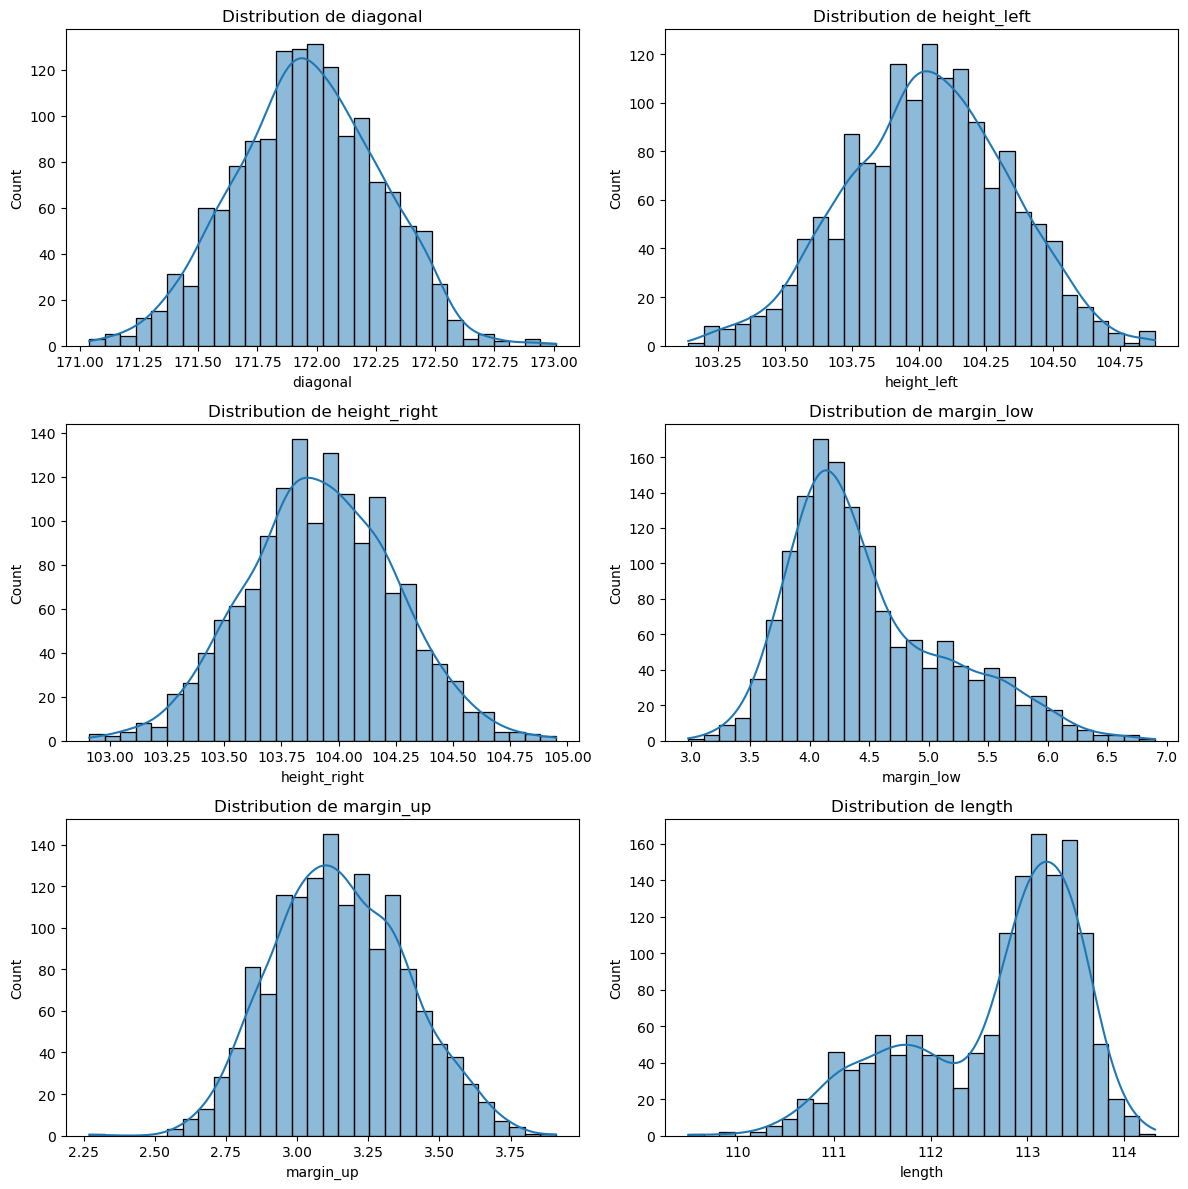

In [20]:
# Définir le nombre de lignes et de colonnes pour l'affichage des graphiques
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 lignes, 2 colonnes

# Aplatir la matrice d'axes pour un accès plus facile dans la boucle
axes = axes.flatten()

for i, num_col in enumerate(colonnes_numeriques):
    sns.histplot(data_without_na[num_col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution de {num_col}")
plt.tight_layout()
plt.show()

Variables avec une distribution gaussienne ==> 'diagonal', 'height_right', 'height_left', 'margin_up' ==> aucune transformation nécessaire  

Variable avec une distribution positivement asymétrique (asymétrique à droite) ==> 'margin_low' ==> transformation logarithmique recommandée pour aider à stabiliser la variance et rendre la distribution plus normale  

Variable avec une distribution négativement asymétrique (asymétrique à gauche) ==> 'length' ==> transformation inverse ou quadratique recommandée pour ajuster la distribution.

## Exploration des transformations

### Transformation logarithmique de margin_low

In [21]:
# Vérification que les valeurs sont positives
if(data_without_na['margin_low'] <= 0).any():
    print("erreur : margin_low contient des valeurs négatives ou nulles, impossible d'applique la transformation logarithmique")
else:
    # transformation log
    data_without_na['log_margin_low'] = np.log(data_without_na['margin_low'])

Observons les différences de distribution

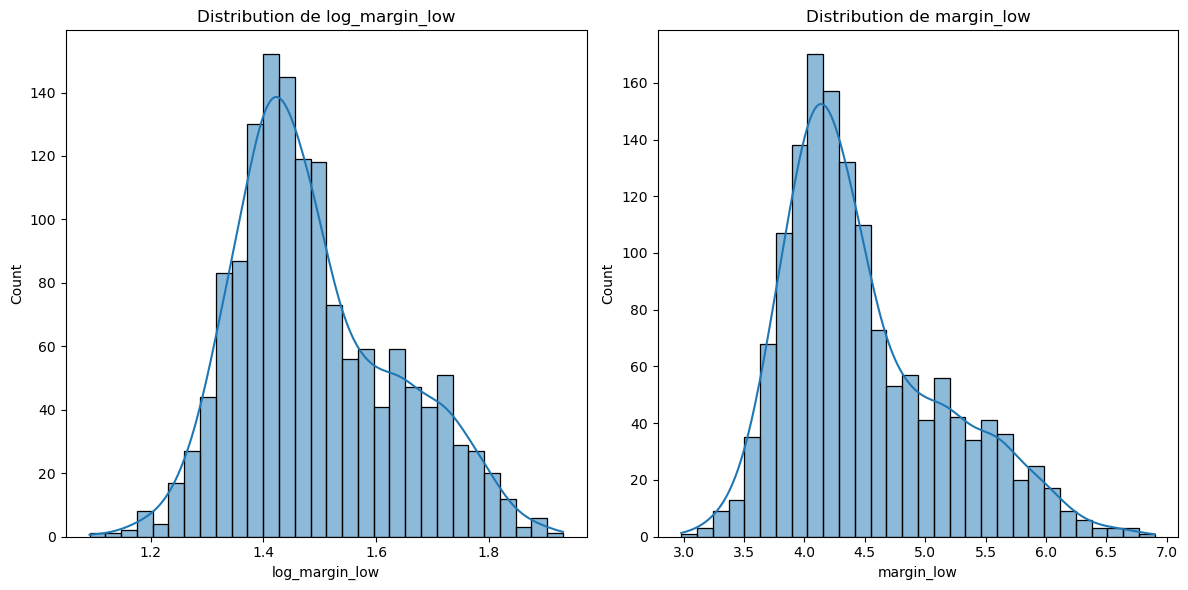

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data_without_na['log_margin_low'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de log_margin_low")

sns.histplot(data_without_na['margin_low'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution de margin_low")

plt.tight_layout()
plt.show()

Après la transformation logarithmique de margin_low, nous réestimons le modèle pour observer les effets.

In [23]:
# Variables prédictives ou indépendantes, on utilise X avec les variables non transformées ==> "X = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]"
# Variables cible ou dépendante on utilise la transformation logarithmique de margin_low
Y_log = data_without_na['log_margin_low']
# création du modèle de régression linéaire multiple
model_log = sm.OLS(Y_log, X)
# ajustement du modèle
results_log = model_log.fit()
# Résumé complet avec les coefficients, p-values...
print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:         log_margin_low   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     261.2
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          1.63e-199
Time:                        09:44:53   Log-Likelihood:                 1248.2
No. Observations:                1463   AIC:                            -2484.
Df Residuals:                    1457   BIC:                            -2453.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.0849      2.075      2.451   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [24]:
# on stocke les résidus du modèle dans une variable
residuals_log = results_log.resid
# Test de Breusch-Pagan
bp_test_log = het_breuschpagan(residuals_log, results_log.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_log[0]}, p-value: {bp_test_log[1]}")

Breusch-Pagan Test Statistic: 32.99634607369279, p-value: 3.7697249620223365e-06


In [25]:
if (bp_test_log[1] < 0.05):
    print(f"Avec une p-value de {bp_test_log[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_log[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation inverse de length

In [26]:
# Vérification que les valeurs sont positives
if(data_without_na['length'] <= 0).any():
    print("erreur : length contient des valeurs négatives ou nulles, impossible d'applique la transformation inverse")
else:
    # transformation inverse
    data_without_na['inv_length'] = 1 / data_without_na['length']

Observons les différences de distribution

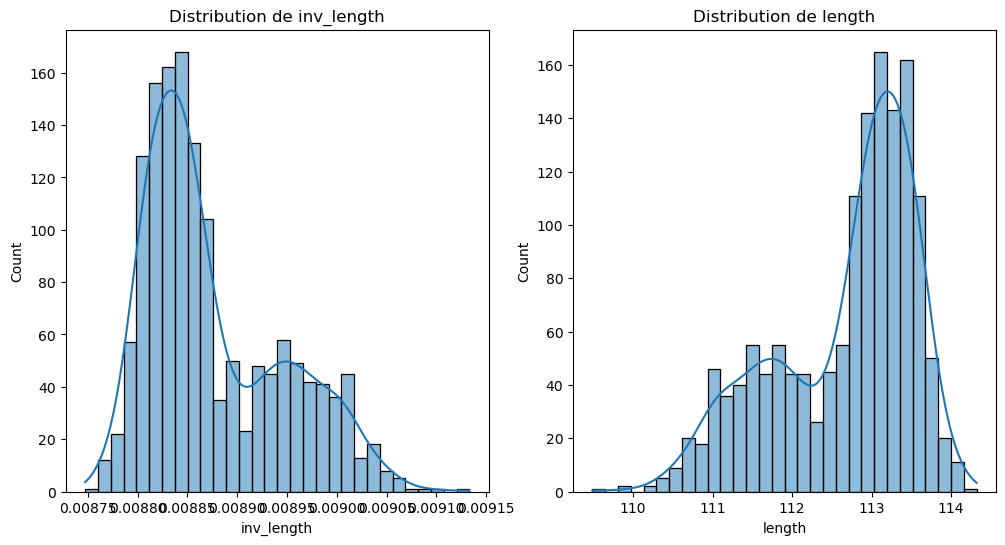

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data_without_na['inv_length'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de inv_length")

sns.histplot(data_without_na['length'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution de length")

plt.show()

Après la transformation inverse de length, nous réestimons le modèle pour observer les effets.

In [28]:
# Variables prédictives ou indépendantes, on utilise X mais on modifie length pour utiliser son inverse
X_inv_length = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'inv_length']]
# Variables cible ou dépendante on utilise Y ==> "Y = data_without_na['margin_low']"
# ajout d'un terme d'interception (intercept) au modèle
X_inv_length = sm.add_constant(X_inv_length)
# création du modèle de régression linéaire multiple
model_inv_length = sm.OLS(Y, X_inv_length)
# ajustement du modèle
results_inv_length = model_inv_length.fit()
# Résumé complet avec les coefficients, p-values...
print(results_inv_length.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          2.64e-202
Time:                        09:44:53   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -68.8640      8.990     -7.660   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [29]:
# on stocke les résidus du modèle dans une variable
residuals_inv_length = results_inv_length.resid
# Test de Breusch-Pagan
bp_test_inv_length = het_breuschpagan(residuals_inv_length, results_inv_length.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_inv_length[0]}, p-value: {bp_test_inv_length[1]}")

Breusch-Pagan Test Statistic: 81.28771742083991, p-value: 4.512111915576294e-16


In [30]:
if (bp_test_inv_length[1] < 0.05):
    print(f"Avec une p-value de {bp_test_inv_length[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_inv_length[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation quadratique de length

In [31]:
data_without_na['quad_length'] = data_without_na['length'] ** 2

Observons les différences de distribution

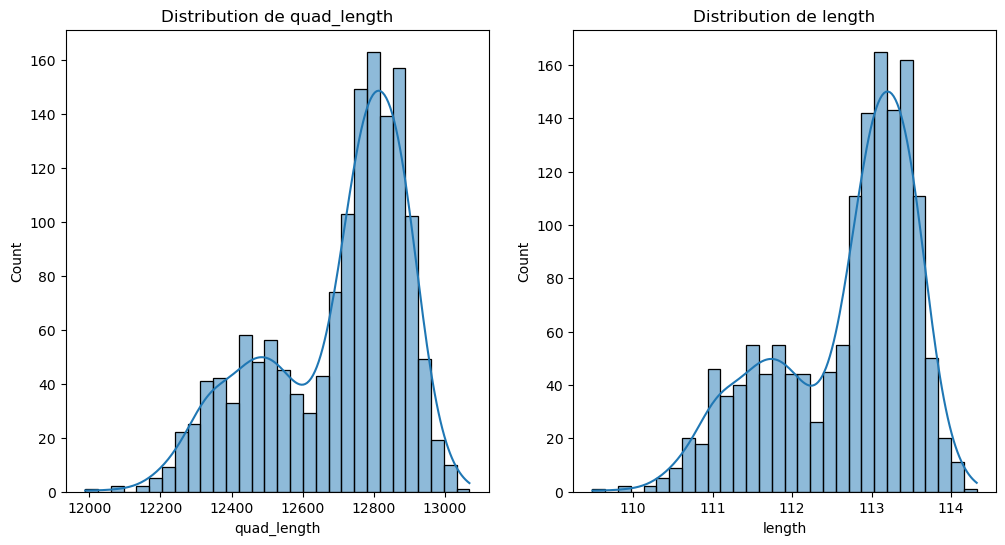

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data_without_na['quad_length'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de quad_length")

sns.histplot(data_without_na['length'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution de length")

plt.show()

Après la transformation quadratique de length, nous réestimons le modèle pour observer les effets.

In [33]:
# Variables prédictives ou indépendantes, on utilise X mais on modifie length pour utiliser son inverse
X_quad_length = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'quad_length']]
# Variables cible ou dépendante on utilise Y ==> "Y = data_without_na['margin_low']"
# ajout d'un terme d'interception (intercept) au modèle
X_quad_length = sm.add_constant(X_quad_length)
# création du modèle de régression linéaire multiple
model_quad_length = sm.OLS(Y, X_quad_length)
# ajustement du modèle
results_quad_length = model_quad_length.fit()
# Résumé complet avec les coefficients, p-values...
print(results_quad_length.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          2.66e-202
Time:                        09:44:54   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0013      9.329     -0.000   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [34]:
# on stocke les résidus du modèle dans une variable
residuals_quad_length = results_quad_length.resid
# Test de Breusch-Pagan
bp_test_quad_length = het_breuschpagan(residuals_quad_length, results_quad_length.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_quad_length[0]}, p-value: {bp_test_quad_length[1]}")

Breusch-Pagan Test Statistic: 79.60726005302945, p-value: 1.0139397768672615e-15


In [35]:
if (bp_test_quad_length[1] < 0.05):
    print(f"Avec une p-value de {bp_test_quad_length[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_quad_length[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation logarithmique de margin_low & inverse de length

Observons les différences de distribution

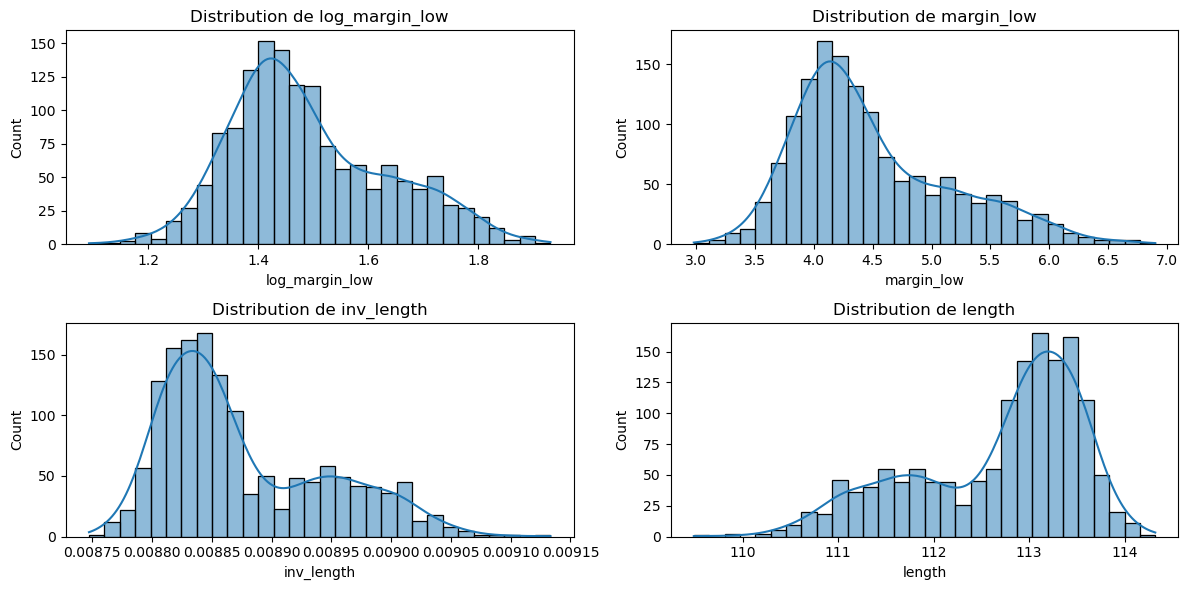

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(data_without_na['log_margin_low'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title("Distribution de log_margin_low")

sns.histplot(data_without_na['margin_low'], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title("Distribution de margin_low")

sns.histplot(data_without_na['inv_length'], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title("Distribution de inv_length")

sns.histplot(data_without_na['length'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title("Distribution de length")

plt.tight_layout()
plt.show()

Après la transformation logarithmique de margin_low & inverse de length, nous réestimons le modèle pour observer les effets.

In [37]:
# création du modèle de régression linéaire multiple
model_transf = sm.OLS(Y_log, X_inv_length)
# ajustement du modèle
results_transf = model_transf.fit()
# Résumé complet avec les coefficients, p-values...
print(results_transf.summary())

                            OLS Regression Results                            
Dep. Variable:         log_margin_low   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     261.2
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          1.66e-199
Time:                        09:44:54   Log-Likelihood:                 1248.2
No. Observations:                1463   AIC:                            -2484.
Df Residuals:                    1457   BIC:                            -2453.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -14.3864      1.932     -7.446   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [38]:
# on stocke les résidus du modèle dans une variable
residuals_transf = results_transf.resid
# Test de Breusch-Pagan
bp_test_transf = het_breuschpagan(residuals_transf, results_transf.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_transf[0]}, p-value: {bp_test_transf[1]}")

Breusch-Pagan Test Statistic: 33.91283029234131, p-value: 2.4780607258143936e-06


In [39]:
if (bp_test_transf[1] < 0.05):
    print(f"Avec une p-value de {bp_test_transf[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_transf[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation logarithmique de margin_low & quadratique de length

Observons les différences de distribution

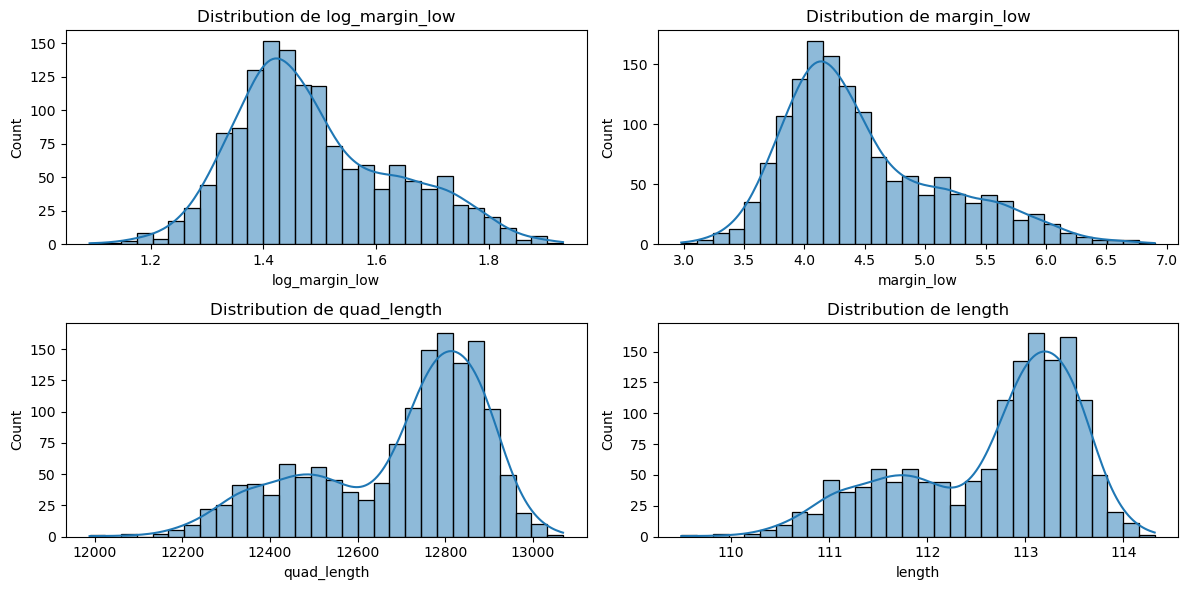

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(data_without_na['log_margin_low'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title("Distribution de log_margin_low")

sns.histplot(data_without_na['margin_low'], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title("Distribution de margin_low")

sns.histplot(data_without_na['quad_length'], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title("Distribution de quad_length")

sns.histplot(data_without_na['length'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title("Distribution de length")

plt.tight_layout()
plt.show()

Après la transformation logarithmique de margin_low & quadratique de length, nous réestimons le modèle pour observer les effets.

In [41]:
# création du modèle de régression linéaire multiple
model_transf_2 = sm.OLS(Y_log, X_quad_length)
# ajustement du modèle
results_transf_2 = model_transf_2.fit()
# Résumé complet avec les coefficients, p-values...
print(results_transf_2.summary())

                            OLS Regression Results                            
Dep. Variable:         log_margin_low   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     261.2
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          1.66e-199
Time:                        09:44:55   Log-Likelihood:                 1248.2
No. Observations:                1463   AIC:                            -2484.
Df Residuals:                    1457   BIC:                            -2453.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2105      2.005      0.105   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [42]:
# on stocke les résidus du modèle dans une variable
residuals_transf_2 = results_transf_2.resid
# Test de Breusch-Pagan
bp_test_transf_2 = het_breuschpagan(residuals_transf_2, results_transf_2.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_transf_2[0]}, p-value: {bp_test_transf_2[1]}")

Breusch-Pagan Test Statistic: 32.54734337825615, p-value: 4.628186342294132e-06


In [43]:
if (bp_test_transf_2[1] < 0.05):
    print(f"Avec une p-value de {bp_test_transf_2[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_transf_2[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation inverse de margin_low

In [44]:
# Vérification que les valeurs sont positives
if(data_without_na['margin_low'] <= 0).any():
    print("erreur : margin_low contient des valeurs négatives ou nulles, impossible d'applique la transformation inverse")
else:
    # transformation inverse
    data_without_na['inv_margin_low'] = 1 / data_without_na['margin_low']

Observons les différences de distribution

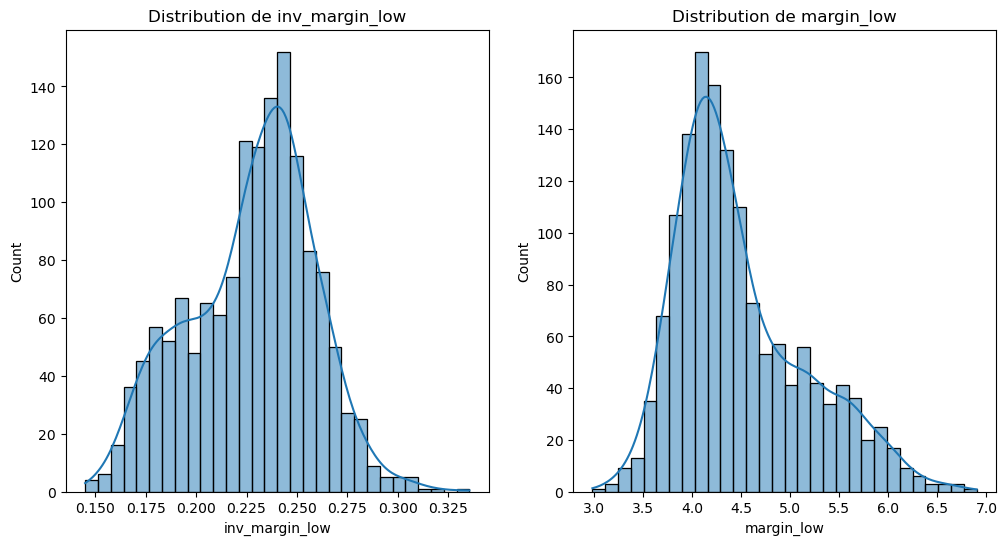

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data_without_na['inv_margin_low'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de inv_margin_low")

sns.histplot(data_without_na['margin_low'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution de margin_low")

plt.show()

Après la transformation inverse de margin_low, nous réestimons le modèle pour observer les effets.

In [46]:
# Variables prédictives ou indépendantes, on utilise X avec les variables non transformées ==> "X = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]"
# Variables cible ou dépendante on utilise la transformation inverse de margin_low
Y_inv = data_without_na['inv_margin_low']
# création du modèle de régression linéaire multiple
model_inv = sm.OLS(Y_inv, X)
# ajustement du modèle
results_inv = model_inv.fit()
# Résumé complet avec les coefficients, p-values...
print(results_inv.summary())

                            OLS Regression Results                            
Dep. Variable:         inv_margin_low   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     245.9
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          1.25e-190
Time:                        09:44:55   Log-Likelihood:                 3447.7
No. Observations:                1463   AIC:                            -6883.
Df Residuals:                    1457   BIC:                            -6852.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4655      0.461     -1.009   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [47]:
# on stocke les résidus du modèle dans une variable
residuals_inv = results_inv.resid
# Test de Breusch-Pagan
bp_test_inv = het_breuschpagan(residuals_inv, results_inv.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_inv[0]}, p-value: {bp_test_inv[1]}")

Breusch-Pagan Test Statistic: 4.518978380375049, p-value: 0.4773482187149264


In [48]:
if (bp_test_inv[1] < 0.05):
    print(f"Avec une p-value de {bp_test_inv[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_inv[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.4773, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Il n'y a donc pas de preuves significatives d'hétéroscédasticité.
Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.


![gif_de_fete](img/giphy.webp)

In [49]:
alpha = 0.05
significant_vars = results_inv.pvalues[(results_inv.pvalues < alpha) & (results_inv.pvalues.index != 'const')]
coef_max_abs = results_inv.params[1:].abs().max()
var_max_name = results_inv.params[1:].abs().idxmax()
coef_max = results_inv.params[var_max_name]

print(f"Le modèle capture une partie importante de la variance, environ {results_inv.rsquared*100:.2f} % mais cela laisse à penser que d'autres facteurs non inclus dans le modèle influencent '{results_inv.model.endog_names}'.\n")  
if not significant_vars.empty:
    print(f"les variables suivantes sont significatives pour la détermination de la variable cible car les p-values sont inférieure au seuil de {alpha}:\n")
    print(significant_vars.to_string(), "\n")
else:
    print(f"Aucune variable n'est significative pour la détermination de la variable cible car les p-values sont supérieur au seuil de {alpha}\n")
print(f"Les 'coef' indiquent l'impact qu'une unité supplémentaire sur la variable indépendante aura sur la variable dépendante.\nOn voit que {var_max_name} a la plus grosse influence avec un coefficient de {coef_max:.2f}.\n\n"
f"Le 'Condition Number' ou 'Cond. No.' est de {results.condition_number:.2f}\n")
if results_inv.condition_number > 30 :
    print(f"C'est un résultat très élevé, ce qui indique une possibilité de multicolinéarité (certaines des variables indép. pourraient être fortement corrélées entre elles).\n")
elif 10< results_inv.condition_number < 30:
    print(f"Ce résultat indique un risque de corrélation modérée, a surveiller")
else:
    print(f"Pas de problème significatif de colinéarité")

print(f"Le test de Durbin-Watson avec un score proche de 2 indique qu'il n'y a probablement pas de forte autocorrélation des résidus (c'est positif pour la validité du modèle).\n")
print(f"Les tests d'Omnibus et Jarque-Bera indique une non-normalité des résidus ce qui pourrait affecter la validité de certaines conclusions.")

Le modèle capture une partie importante de la variance, environ 45.76 % mais cela laisse à penser que d'autres facteurs non inclus dans le modèle influencent 'inv_margin_low'.

les variables suivantes sont significatives pour la détermination de la variable cible car les p-values sont inférieure au seuil de 0.05:

diagonal        2.030036e-02
height_left     8.128584e-05
height_right    2.700965e-09
margin_up       7.068436e-05
length          1.071629e-89 

Les 'coef' indiquent l'impact qu'une unité supplémentaire sur la variable indépendante aura sur la variable dépendante.
On voit que length a la plus grosse influence avec un coefficient de 0.02.

Le 'Condition Number' ou 'Cond. No.' est de 194200.03

C'est un résultat très élevé, ce qui indique une possibilité de multicolinéarité (certaines des variables indép. pourraient être fortement corrélées entre elles).

Le test de Durbin-Watson avec un score proche de 2 indique qu'il n'y a probablement pas de forte autocorrélation des résid

Nous avons réalisé une régréssion linéaire avec transformation inverse de la variable dépendante 'margin_low' et nous avons constaté :  
- Que toutes les variables étaient significatives pour déterminer 'margin_low'.  
- Qu'il n'y avait pas de problème de colinéarité entre les variables.
- Que nous avions des résidus homoscédastiques.
- Que notre modèle expliquait près de 45 % de la variance.

Nous allons procéder au remplacement des NaN de la colonne 'margin_low' à l'aide de cette régression linéaire.

## Remplacement des valeurs manquantes

On va utiliser notre modèle retenu 'results_inv' pour prédire les valeurs manquantes de 'margin_low'

In [50]:
data_with_na = data[data['margin_low'].isna()] # On isole la partie de data avec les 37 lignes ou il y a des valeurs manquantes dans margin_low
# Etape 1 : sélection des variables explicatives des lignes avec NaN
X_missing = data_with_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
# Ajout d'une constante comme dans notre modèle
X_missing = sm.add_constant(X_missing)
# Etape 2 : Prédiction des valeurs inverses de margin low en utilisant le modèle results_inv
predict_inv = results_inv.predict(X_missing)
# Etape 3 : Transformation des prédictions inverse pour revenir aux valeurs d'"origine"
predict_margin_low = 1 / predict_inv
# Etape 4 : Remplacer les NaN par les predictions dans data 
data.loc[data["margin_low"].isna(), 'margin_low'] = predict_margin_low

Nous pouvons vérifier que les lignes pour lesquelles les valeurs étaient manquantes ont désormais une valeur 'margin_low'

In [54]:
missing_indices = data_with_na.index
data_predicted_raw = data.loc[missing_indices]
data_predicted_raw.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.249525,3.25,112.79
99,True,171.93,104.07,104.18,4.319269,3.14,113.08
151,True,172.07,103.80,104.38,4.335315,3.02,112.93
197,True,171.45,103.66,103.80,4.253347,3.62,113.27
241,True,171.83,104.14,104.06,4.545341,3.02,112.36


Puis nous pouvons vérifier la cohérence des valeurs de margin_low en comparant la moyenne des valeurs prédites avec le reste du dataframe pour s'assurer que tout est ok

In [62]:
print(f" La moyenne des valeurs prédites est : {data_predicted_raw['margin_low'].mean():.2f}")
print(f" La moyenne des valeurs d'origine est : {data_without_na['margin_low'].mean():.2f}")

 La moyenne des valeurs prédites est : 4.35
 La moyenne des valeurs d'origine est : 4.49


Le résultat est cohérent et assez proche de la moyenne du reste des données.  
Nous pouvons poursuivre et désormais définir un modèle de détection de faux billets.

# II- Construction d'un modèle de prédiction

## Méthodes non supervisées : ACP et clustering K-means pour la détection des faux billets

### Boxplot des variables prédictives

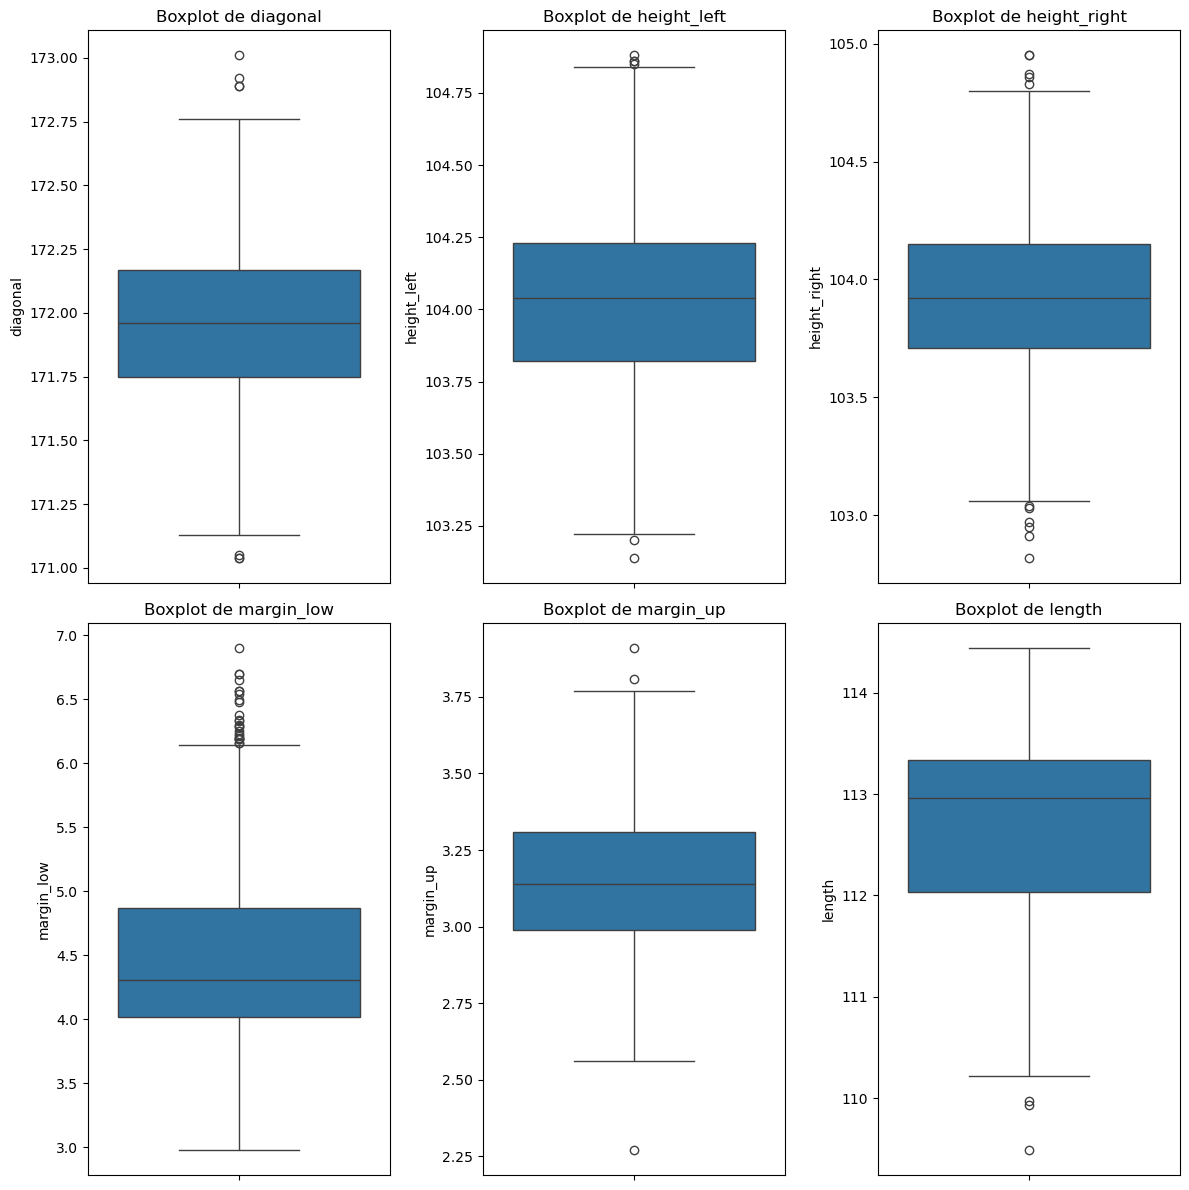

In [70]:
# definition des variables prédictives
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# Créer une figure avec des sous-graphes
fig, axes = plt.subplots(2, 3, figsize=(12, 12))

# Aplatir les axes pour un accès plus facile
axes = axes.flatten()

# boxplot avec seaborn
for i, feat in enumerate(features):
    sns.boxplot(data=data[feat], ax=axes[i])
    axes[i].set_title(f"Boxplot de {feat}")

plt.tight_layout()
plt.show()

### Nuages de points des paires de variables

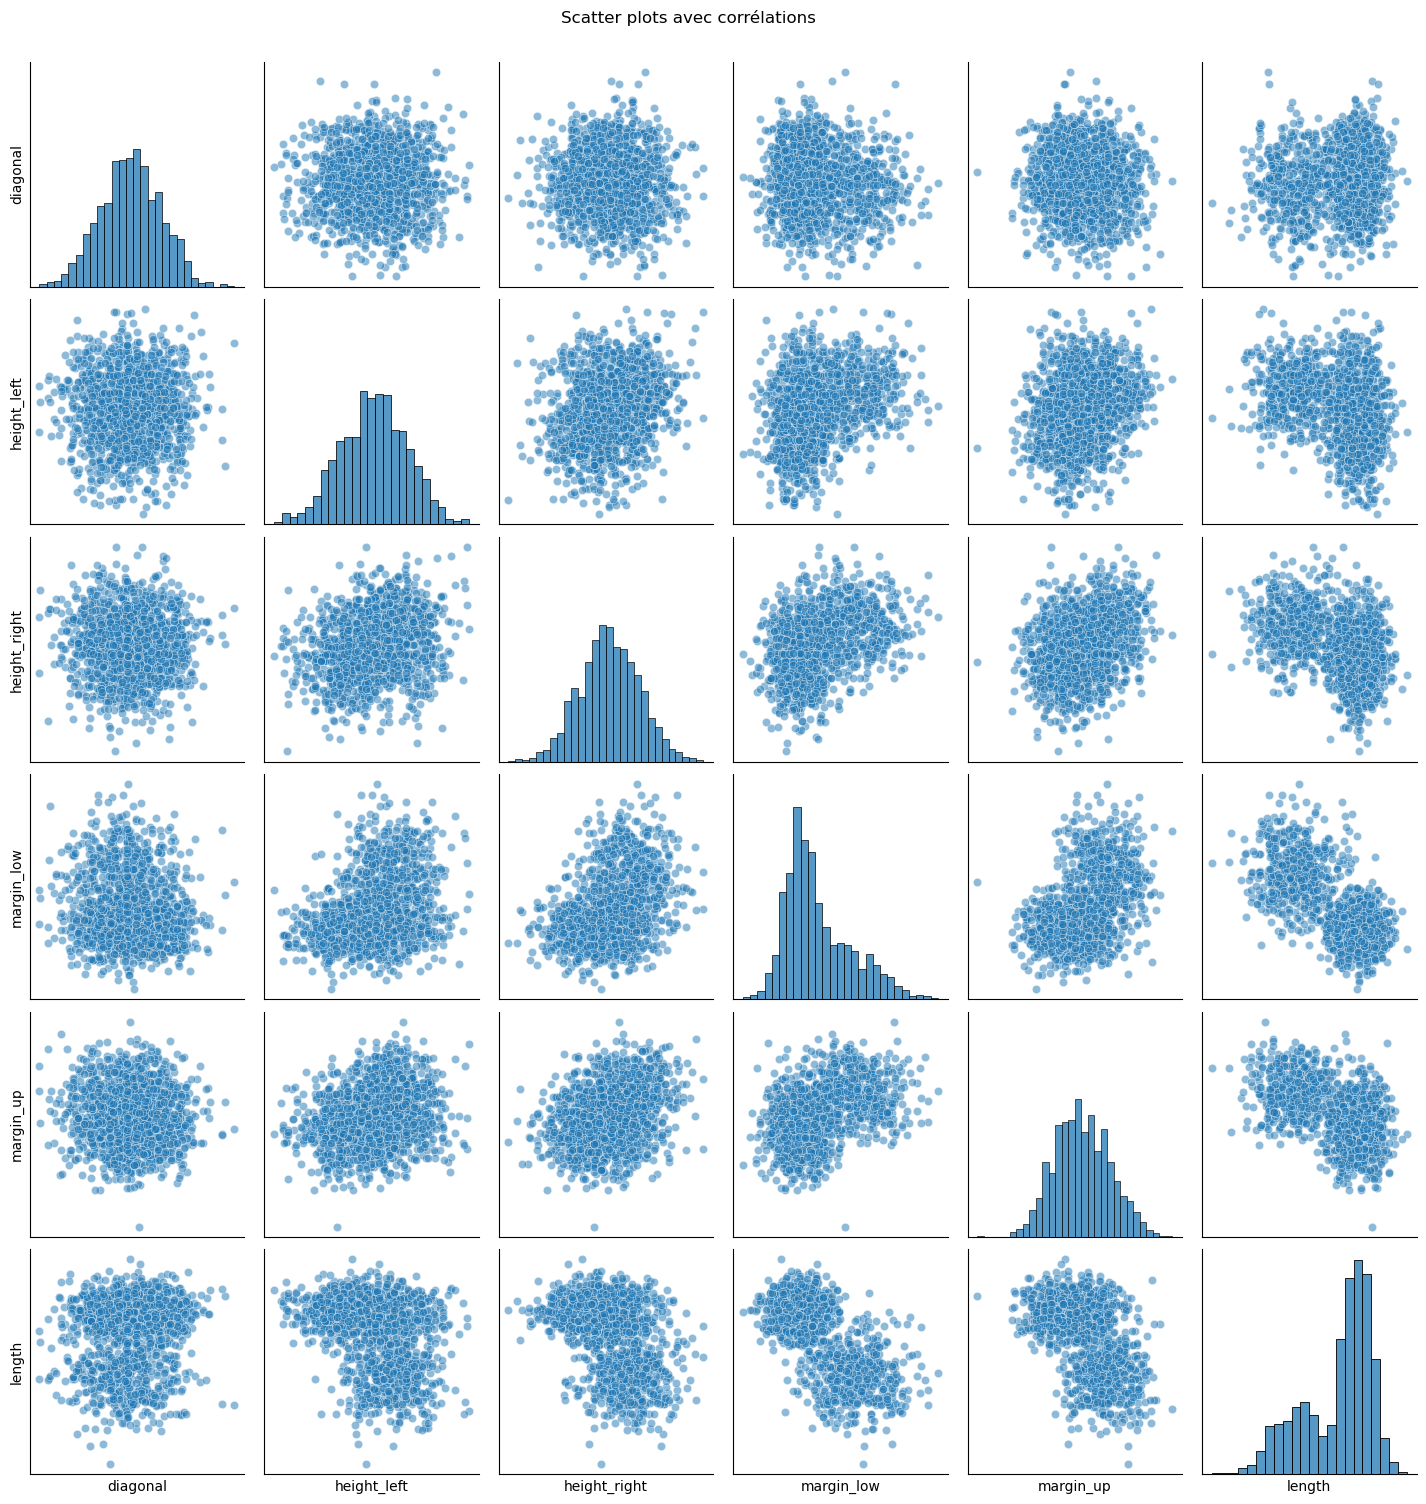

In [73]:
# création de pairplot avec seaborn
pairplot = sns.pairplot(data[features],
                        diag_kind = 'hist', # histogrammes sur la diagonale
                        plot_kws = {'alpha': 0.5}) # ajuster la transparence des points

# Titre
pairplot.fig.suptitle("Scatter plots avec corrélations", y=1.02) # ajustement de la position du titre

# Personnalisation des axes
for ax in pairplot.axes.flatten():
    ax.xaxis.set_tick_params(labelbottom=False) # supprime les étiquettes de l'axe x
    ax.yaxis.set_tick_params(labelleft=False) # supprime les étiquettes de l'axe y
    ax.tick_params(axis='both', which='both', length=0) # supprime les ticks

plt.show()

On remarque quelques corrélations notamment entre les variables 'length' et 'margin_low ou 'lenght' et 'margin_up'.  
Cependant les corrélations ne sont pas évidentes et linéaires.

### Méthode du Z-score pour détecter les valeurs atypiques

In [94]:
# création d'une fonction pour détecter les outliers
def detect_outliers_zscore(df, threshold=3):
    outliers = {}
    for column in df.select_dtypes(include=['float64', 'int']).columns:
        # calcul du zscore
        z_scores = np.abs(stats.zscore(df[column].dropna()))
        # detection outliers
        outliers[column] = df[column][z_scores > threshold]
    return outliers

data_outliers = detect_outliers_zscore(data)

# Afficher le nombre total d'outliers
total_outliers = sum(len(v) for v in data_outliers.values())  # Compte total d'outliers
print(f"Il y a {total_outliers} lignes contenant des outliers.\n")

# Affichage des outliers pour chaque variable
for feat, outliers in data_outliers.items():
    print(f"Outliers pour la variable {feat} :\n")
    print(outliers, "\n________________________\n")

all_indices_outliers = set()

for outliers in data_outliers.values():
    indices_outliers = outliers.index.tolist()
    all_indices_outliers.update(indices_outliers)

all_indices_outliers = sorted(list(all_indices_outliers))
print(f"Indices des outliers : {all_indices_outliers}")

Il y a 24 lignes contenant des outliers.

Outliers pour la variable diagonal :

729     171.04
828     172.92
842     172.89
1022    172.89
1142    171.04
1277    173.01
Name: diagonal, dtype: float64 
________________________

Outliers pour la variable height_left :

Series([], Name: height_left, dtype: float64) 
________________________

Outliers pour la variable height_right :

0       104.95
251     102.82
522     102.91
1484    104.95
Name: height_right, dtype: float64 
________________________

Outliers pour la variable margin_low :

1027    6.70
1041    6.65
1110    6.56
1124    6.70
1169    6.48
1254    6.49
1290    6.90
1441    6.56
1464    6.54
Name: margin_low, dtype: float64 
________________________

Outliers pour la variable margin_up :

664     2.27
1029    3.91
Name: margin_up, dtype: float64 
________________________

Outliers pour la variable length :

1082    109.49
1355    109.97
1453    109.93
Name: length, dtype: float64 
________________________

Indices des outl

### Suppression des lignes d'outliers pour ACP et Clustering

In [96]:
data_without_outliers = data[~data.index.isin(all_indices_outliers)] # On sélectionne les lignes de data dont les indices ne sont pas dans 'all_indices_outliers'

In [97]:
data_without_outliers.info() # on vérifie la composition du dataframe et on constate qu'il y a bien eu 24 lignes supprimées

<class 'pandas.core.frame.DataFrame'>
Index: 1476 entries, 1 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1476 non-null   bool   
 1   diagonal      1476 non-null   float64
 2   height_left   1476 non-null   float64
 3   height_right  1476 non-null   float64
 4   margin_low    1476 non-null   float64
 5   margin_up     1476 non-null   float64
 6   length        1476 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 82.2 KB


Pour l'ACP nous ne conserverons que les colonnes numériques et supprimons 'is_genuine'  
Le but final étant d'observer le résultat d'une classification non supervisée pour déterminer 'is_genuine' en fonction des dimensions

In [103]:
data_acp = data_without_outliers.select_dtypes(include=[np.number]) # On exclu les colonnes non numériques
data_acp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1476 entries, 1 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1476 non-null   float64
 1   height_left   1476 non-null   float64
 2   height_right  1476 non-null   float64
 3   margin_low    1476 non-null   float64
 4   margin_up     1476 non-null   float64
 5   length        1476 non-null   float64
dtypes: float64(6)
memory usage: 80.7 KB


### ACP ou Analyse en Composante Principale

#### Matrice des coefficients de chargement des composantes principales

In [121]:
# Chargement des données et prétraitement
X = data_acp.values  # Convertir le DataFrame en une matrice NumPy X avec les valeurs de data_acp

# Standardisation des données
scaler = StandardScaler()  # Initialiser le scaler
X_scaled = scaler.fit_transform(X)  # Appliquer la standardisation aux données
# Cette fonction centre en soustrayant la moyenne de chaque variable ce qui donnera une moyenne à 0
# Puis cela réduit en divisant par l'écart-type de chaque variable ce qui donnera un écart-type de 1

# Analyse en composantes principales (PCA)
n_components = len(features)  # Nombre de composantes principales à extraire
pca = PCA(n_components=n_components)  # Initialiser l'objet PCA avec le nombre de composantes
pca.fit(X_scaled)  # Appliquer PCA aux données standardisées

# Calcul des variances expliquées
scree = (pca.explained_variance_ratio_ * 100).round(2)  # Variance expliquée en pourcentage
scree_cum = scree.cumsum().round()  # Variance expliquée cumulative
x_list = range(1, n_components + 1)  # Liste des composantes principales

# Récupération des composantes principales
pcs = pca.components_  # Composantes principales
pcs = pd.DataFrame(pcs)  # Convertir en DataFrame pour une meilleure lisibilité
pcs.columns = features  # Nommer les colonnes avec les noms des caractéristiques
pcs.index = [f"F{i}" for i in x_list]  # Nommer les lignes avec les numéros de composante F1, F2 etc...
pcs_rounded = pcs.round(2)  # Arrondir les valeurs à deux décimales

# Transposer les composantes principales pour une meilleure lisibilité
pcs_T = pcs.T  # Transposer le DataFrame des composantes principales

# Affichage du résultat final (pcs_T) dans la cellule suivante
print("DataFrame des composantes principales transposé :\nCoefficients de contribution (ou poids) associés à chaque variable dans chaque composante principale\nPlus la valeur est élevée (en valeur absolue), plus cette variable contribue fortement à la composante principale en question")
pcs_T

DataFrame des composantes principales transposé :
Coefficients de contribution (ou poids) associés à chaque variable dans chaque composante principale
Plus la valeur est élevée (en valeur absolue), plus cette variable contribue fortement à la composante principale en question


,F1,F2,F3,F4,F5,F6
diagonal,0.079616,0.944375,-0.278841,-0.091578,-0.124891,0.009019
height_left,-0.332305,0.304630,0.884187,-0.006158,0.122242,0.002442
height_right,-0.391382,0.086105,-0.200105,0.868408,0.212390,0.011062
margin_low,-0.508073,-0.075044,-0.089874,-0.112756,-0.562378,0.631799
margin_up,-0.440364,0.007727,-0.270639,-0.438783,0.715766,0.167102
length,0.527254,0.047449,0.138187,0.179441,0.309451,0.756768


#### Eboulis des valeurs propres et Heatmap des coefficients de chargement de l'ACP

Nous allons maintenant observer l'éboulis des valeurs propres et observer le tableau précédent sous forme d'une Heatmap

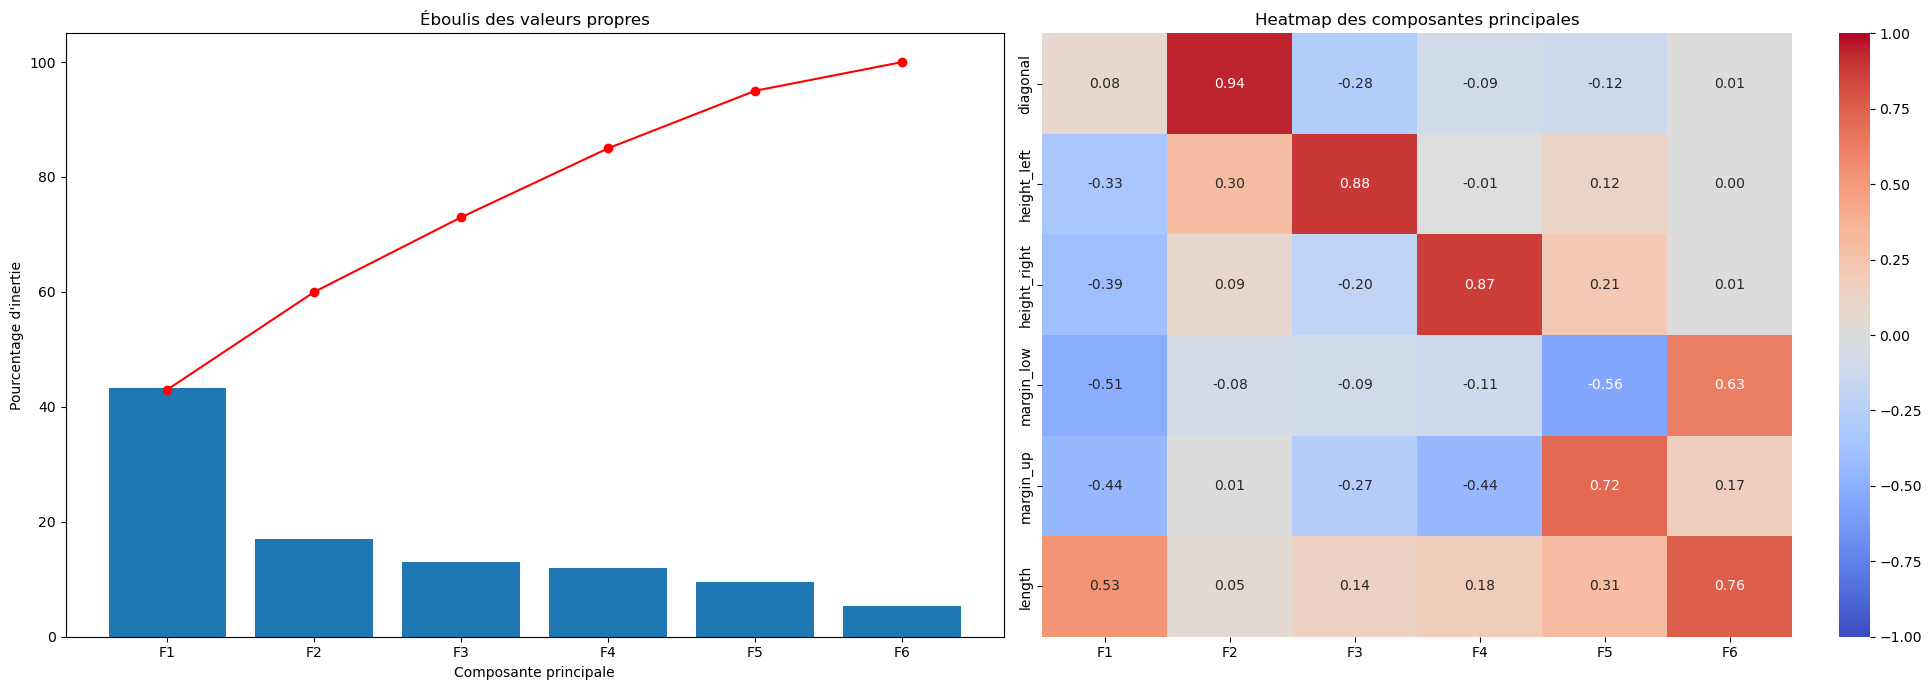

In [106]:
# Création des étiquettes pour les axes d'inertie
x_labels = pcs.index
y_labels = pcs_T.index
# Créer une figure et des axes pour les sous-plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot 1: Scree plot
axes[0].bar(x_list, scree)
axes[0].plot(x_list, scree_cum, c="red", marker='o')
axes[0].set_xticks(x_list)
axes[0].set_xticklabels(x_labels)
axes[0].set_xlabel("Composante principale")
axes[0].set_ylabel("Pourcentage d'inertie")
axes[0].set_title("Éboulis des valeurs propres")

# Plot 2: Heatmap
sns.heatmap(
    pcs_T, 
    vmin=-1, 
    vmax=1, 
    annot=True, 
    cmap="coolwarm", 
    fmt="0.2f", 
    ax=axes[1], 
    yticklabels=y_labels, 
    xticklabels=x_labels
)
axes[1].set_title("Heatmap des composantes principales")

plt.tight_layout()
plt.show()

#### Transformation des données avec l'ACP

In [129]:
n_components = 4  # Nombre de composantes principales à extraire
pca = PCA(n_components=n_components)  # Initialiser l'objet PCA avec le nombre de composantes
pca.fit(X_scaled)  # Appliquer PCA aux données standardisées

x_list = range(1, n_components + 1)  # Liste des composantes principales

# Récupération des composantes principales
pcs = pca.components_  # Composantes principales
pcs = pd.DataFrame(pcs)  # Convertir en DataFrame pour une meilleure lisibilité
pcs.columns = features  # Nommer les colonnes avec les noms des caractéristiques
pcs.index = [f"F{i}" for i in x_list]  # Nommer les lignes avec les numéros de composante
pcs_rounded = pcs.round(2)  # Arrondir les valeurs à deux décimales

composantes_no = pcs.index # Stock le nom des composantes retenues

# Transposer les composantes principales pour une meilleure lisibilité
pcs_T = pcs.T  # Transposer le DataFrame des composantes principales

# Affichage du résultat final (pcs_T) dans la cellule suivante
print("DataFrame des composantes principales transposé :")
pcs_T

DataFrame des composantes principales transposé :


,F1,F2,F3,F4
diagonal,0.079616,0.944375,-0.278841,-0.091578
height_left,-0.332305,0.304630,0.884187,-0.006158
height_right,-0.391382,0.086105,-0.200105,0.868408
margin_low,-0.508073,-0.075044,-0.089874,-0.112756
margin_up,-0.440364,0.007727,-0.270639,-0.438783
length,0.527254,0.047449,0.138187,0.179441


In [130]:
X_projection = pca.transform(X_scaled)
X_projection = pd.DataFrame(data=X_projection, columns=composantes_no)
X_projection

,F1,F2,F3,F4
0,2.030062,-2.223369,-1.005056,-0.018836
1,0.941712,2.676175,1.248407,-0.851346
2,1.389333,-1.860590,0.606862,0.833394
3,-0.170440,-0.534311,0.888333,-1.759678
4,0.670494,0.418549,-0.891242,0.795024
...,...,...,...,...
1471,-1.469822,-0.306468,0.926822,0.566448
1472,-3.365060,1.298227,0.590079,0.406876
1473,-1.959780,-0.622174,-0.548067,-0.145189
1474,-1.854632,0.515599,0.025343,-0.460575


In [142]:
# Fonction pour dessiner le cercle des corrélations
def correlation_circle(pca, features, ax, dim1=0, dim2=1):
    """
    Trace le cercle des corrélations pour une analyse en composantes principales (PCA).
    
    Parameters:
    - pca: L'objet PCA qui contient les composantes principales et la variance expliquée.
    - features: Liste des noms des caractéristiques d'origine.
    - ax: Axes de Matplotlib pour tracer le cercle des corrélations.
    - dim1: Indice de la première dimension à tracer (par défaut 0 pour F1).
    - dim2: Indice de la deuxième dimension à tracer (par défaut 1 pour F2).
    
    Returns:
    - None: La fonction trace directement sur les axes fournis.
    """
    pcs = pca.components_
    n_pcs = len(pcs)
    
    # Plot circle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax.add_artist(circle)
    
    for i, (x, y) in enumerate(zip(pcs[dim1, :], pcs[dim2, :])):
        ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, fc='orange', ec='orange')
        ax.text(x * 1.15, y * 1.15, features[i], color='black', ha='center', va='center')

    ax.set_xlabel(f'F{dim1 + 1} ({round(100 * pca.explained_variance_ratio_[dim1], 2)}%)')
    ax.set_ylabel(f'F{dim2 + 1} ({round(100 * pca.explained_variance_ratio_[dim2], 2)}%)')
    
    # Calculer les limites dynamiques
    x_max = np.max(np.abs(pcs[dim1, :]))
    y_max = np.max(np.abs(pcs[dim2, :]))
    lim = max(x_max, y_max) * 1.2  # Ajouter une marge de 10%

    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.set_aspect('equal')    # Ensure the plot is square
    ax.axis('on')             # Display axes
    ax.axhline(0, color='gray', linestyle='--')  # Horizontal line at y=0
    ax.axvline(0, color='gray', linestyle='--')  # Vertical line at x=0

# Fonction pour dessiner la projection des individus
def factorial_planes(X_projection, pca, ax, dim1=0, dim2=1):
    """
    Trace les projections des individus sur les plans factoriels de l'ACP.
    
    Parameters:
    - X_projection: Les données projetées sur les composantes principales.
    - pca: L'objet PCA qui contient la variance expliquée par chaque composante.
    - ax: Axes de Matplotlib pour tracer les projections des individus.
    - dim1: Indice de la première dimension à tracer (par défaut 0 pour F1).
    - dim2: Indice de la deuxième dimension à tracer (par défaut 1 pour F2).
    
    Returns:
    - None: La fonction trace directement sur les axes fournis.
    """
    ax.scatter(X_projection[:, dim1], X_projection[:, dim2], alpha=0.6)
    ax.set_xlabel(f'F{dim1 + 1} ({round(100 * pca.explained_variance_ratio_[dim1], 2)}%)')
    ax.set_ylabel(f'F{dim2 + 1} ({round(100 * pca.explained_variance_ratio_[dim2], 2)}%)')
    ax.grid()

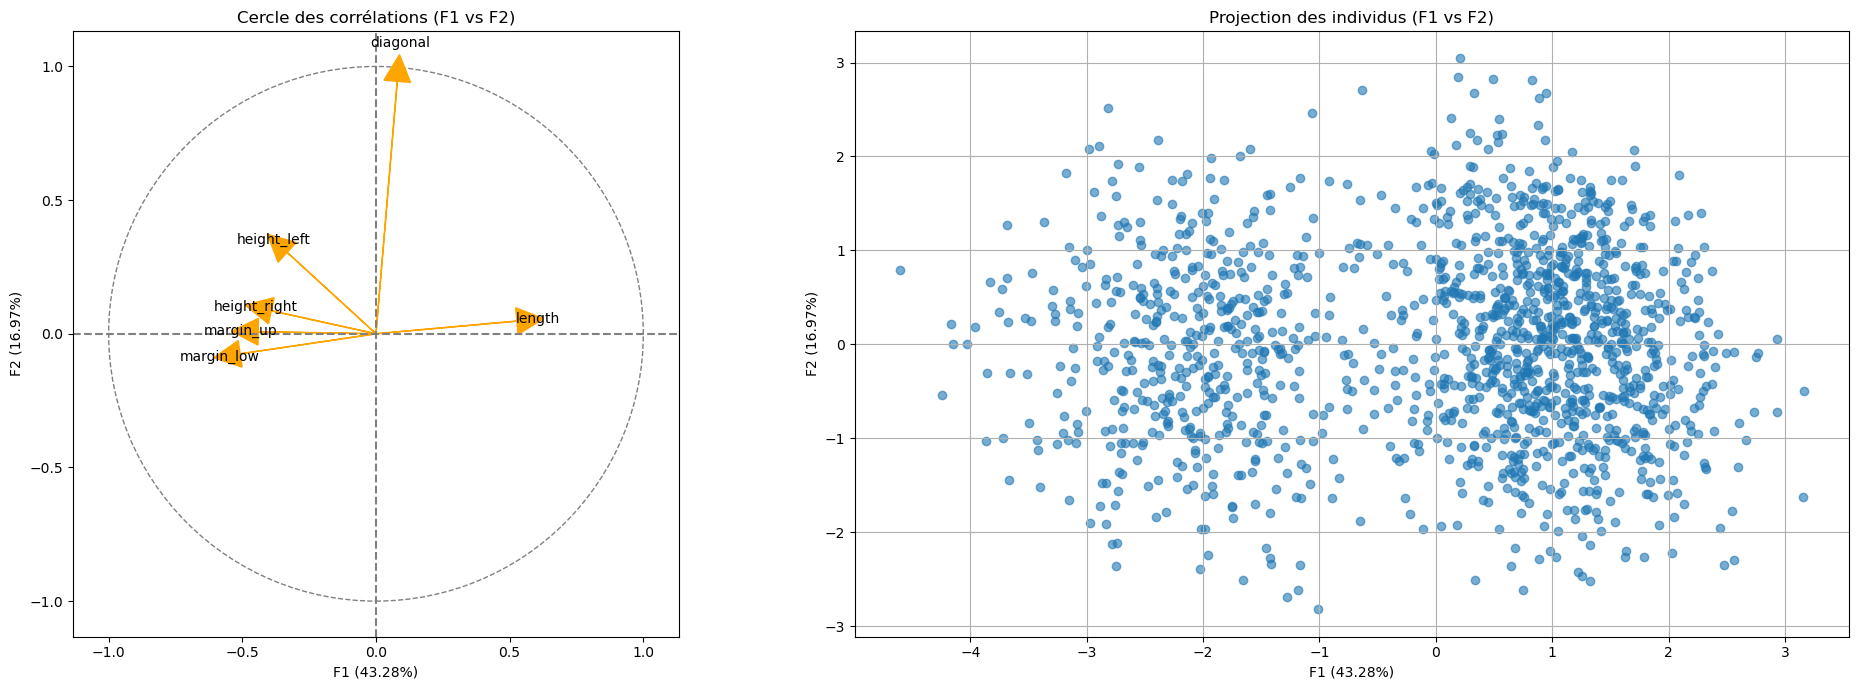

In [143]:
# Créer une figure et des axes pour les sous-plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot 3: Correlation circle (Cercle des corrélations)
correlation_circle(pca, features, ax=axes[0], dim1=0, dim2=1)  # F1 and F2
axes[0].set_title("Cercle des corrélations (F1 vs F2)")

# Plot 4: Factorial planes (Projection des individus)
factorial_planes(X_projection.values, pca, ax=axes[1], dim1=0, dim2=1)  # F1 and F2
axes[1].set_title("Projection des individus (F1 vs F2)")

plt.tight_layout()
plt.show()